In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('baseballs.csv')
df.head()

,batting_avg,runs_scored,doubles_at_bat,triples_at_bat,home_run,strike_outs
0,0.283,0.144,0.049,0.012,0.013,0.086
1,0.276,0.125,0.039,0.013,0.002,0.062
2,0.281,0.141,0.045,0.021,0.013,0.074
3,0.328,0.189,0.043,0.001,0.030,0.032
4,0.290,0.161,0.044,0.011,0.070,0.076


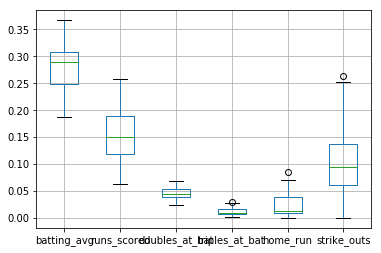

In [3]:
df.boxplot()

In [7]:
def out(df_in,col):
    q1 = df_in[col].quantile(0.25)
    q3 = df_in[col].quantile(0.75)
    IQR = q3-q1
    uw = q3+(1.5*IQR)
    lw = q1-(1.5*IQR)
    df_out = df_in[~((df_in>uw)|(df_in<lw)).any(axis=1)]
    return df_out

In [8]:
df.shape

(45, 6)

In [9]:
df1 = out(df,df.columns)
df1.shape

(42, 6)

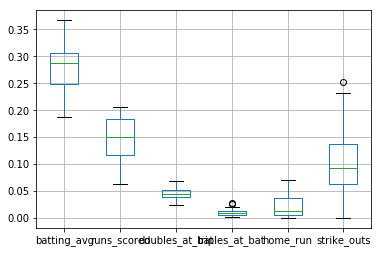

In [10]:
df1.boxplot()

## The above boxplot shows the new data has outliers based on new data

# OLS Method

In [11]:
x = df1.drop('batting_avg',axis=1)
y = df1.batting_avg

In [14]:
import statsmodels.api as sm

x_constant = sm.add_constant(x)
lr = sm.OLS(y,x_constant).fit()
lr.summary()

C:\Users\KUS\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            batting_avg   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     44.03
Date:                Wed, 04 Sep 2019   Prob (F-statistic):           2.35e-14
Time:                        17:19:20   Log-Likelihood:                 113.52
No. Observations:                  42   AIC:                            -215.0
Df Residuals:                      36   BIC:                            -204.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1796      0.018      9.795      0.000       0.142       0.217
runs_scored        0.4573      0.114      4.003      0.000       0.226       0.689
doubles_at_bat     0.9969      0.317      3.140      0.003       0.353       1.641
triples_at_bat     0.8622      0.623      1.384      0.175      -0.401       2.125
home_run           0.2569      0.173      1.487      0.146      -0.094       0.607
strike_outs       -0.2867      0.058     -4.919      0.000      -0.405      -0.168
==============================================================================
Omnibus:                        0.033   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.984   Jarque-Bera (JB):                0.126
Skew:                           0.059   Prob(JB):                        0.939
Kurtosis:                       2.759   Cond. No.                         241.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Assumption 1 - Auto Correlation

C:\Users\KUS\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


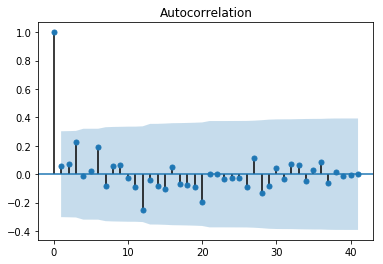

In [21]:
import statsmodels.tsa.api as smt
acf = smt.graphics.plot_acf(lr.resid)
acf.show()

## The inference here is that the residuals are not auto correlated

# Assumption 2 - Normality Tets

In [22]:
from scipy import stats
stats.jarque_bera(lr.resid)

(0.1255910847149446, 0.9391354674848611)

## As the JB value is below 5.99 ... hence the residual are normal .. 

# Assumption 3 - Linearity of Residuals

### Mean Method

In [23]:
lr.resid.mean()

1.6983768888611024e-16

### Rainbow Test

In [25]:
import statsmodels.api as sm
sm.stats.diagnostic.linear_rainbow(res=lr)

(1.0696694915346214, 0.4554645617677656)

##  Here the Null HYp holds ... And hence the residuals are linear

### Probplot Method

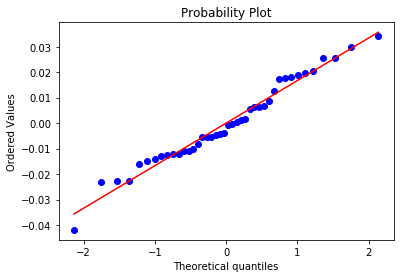

In [27]:
stats.probplot(lr.resid,dist='norm',plot=plt)
plt.show()

In [29]:
fitted_values = lr.predict()
resid = lr.resid

Text(0.5, 1.0, 'Predicted vs Actual')

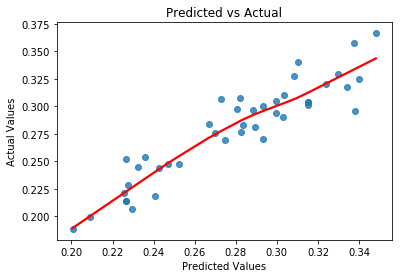

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.regplot(x = fitted_values, y = y, lowess= True, line_kws={'color':'red'})
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Predicted vs Actual')

Text(0.5, 1.0, 'Predicted vs Actual')

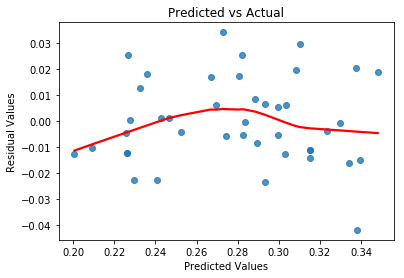

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.regplot(x = fitted_values, y = resid, lowess= True, line_kws={'color':'red'})
plt.xlabel('Predicted Values')
plt.ylabel('Residual Values')
plt.title('Predicted vs Actual')

# Assumption 4 - Scedasticity Test

### Goldfeld Test

In [28]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
name = ['F-Stat','p-val']
test = sms.het_goldfeldquandt(lr.resid,lr.model.exog)
lzip(name,test)

[('F-Stat', 0.5016134533059529), ('p-val', 0.9034552110848544)]

## Here the Null Hyp holds and hence the residuals are Homo Scedastic in nature

# Assumption 5 - Multi Collinearity

In [32]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = [variance_inflation_factor(x_constant.values,i) for i in range(x_constant.shape[1])]
pd.DataFrame({'vif':vif[0:]},index = x_constant.columns)

,vif
const,46.051913
runs_scored,2.633386
doubles_at_bat,1.468540
triples_at_bat,2.189409
home_run,1.674171
strike_outs,1.591548


## Here the VIF values are in the range 1 to 5 hence there in no multicollinearity

# Evaluation Parameters

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=1)
lr = LinearRegression()
lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)

In [38]:
lr.score(x_train,y_train)

0.8590045824107527

In [39]:
lr.score(x_test,y_test)

0.8147536436359726

In [41]:
from sklearn import metrics
mae = metrics.mean_absolute_error(y_test,y_pred)
mse = metrics.mean_squared_error(y_test,y_pred)
RMSE = np.sqrt(mse)
print(mae,mse,RMSE)

0.01884066450382581 0.0004702648656805197 0.021685591199700312


## The final inference is that the model is perfectly balanced with 85% training accuracy and 81% test accuracy with minimal errors.